In [39]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [21]:

df = pd.read_csv(r'C:\Users\Stefano\Desktop\Tesi\recomm_retail_b2b.csv')


In [36]:
mean_orders = df['NUMBER_ORDERS'].mean()

mode_orders = df['NUMBER_ORDERS'].mode()[0]

max_order = df['NUMBER_ORDERS'].max()

mean_pieces = df['NUMBER_PIECES'].mean() if 'NUMBER_PIECES' in df.columns else None

mode_pieces = df['NUMBER_PIECES'].mode()[0] if 'NUMBER_PIECES' in df.columns else None

max_pieces = df['NUMBER_PIECES'].max() if 'NUMBER_PIECES' in df.columns else None

most_frequent_category = df['PRODUCT_CATEGORY'].mode()[0] if 'PRODUCT_CATEGORY' in df.columns else None

print(f"Average number of orders: {mean_orders}")
print(f"Mode of the number of orders: {mode_orders}")
print(f"Largest order: {max_order}")
print(f"Average number of pieces ordered: {mean_pieces}")
print(f"Mode of the number of pieces ordered: {mode_pieces}")
print(f"Largest number of pieces ordered: {max_pieces}")
print(f"Most frequent product category: {most_frequent_category}")

Average number of orders: 1.7809376077214754
Mode of the number of orders: 1
Largest order: 500
Average number of pieces ordered: 24.50482592209583
Mode of the number of pieces ordered: 1
Largest number of pieces ordered: 14808
Most frequent product category: C30


In [37]:

unique_customers = df['ID_CLIENT'].nunique()

unique_products = df['ID_PRODUCT'].nunique()

print(f"Number of unique customers: {unique_customers}")
print(f"Number of unique products: {unique_products}")

Number of unique customers: 936
Number of unique products: 3175


In [38]:
order_frequency_by_customer = df.groupby('ID_CLIENT')['NUMBER_ORDERS'].sum()
average_orders_per_customer = order_frequency_by_customer.mean()

product_popularity = df.groupby('ID_PRODUCT')['NUMBER_ORDERS'].sum()
average_orders_per_product = product_popularity.mean()

print(f"Number of unique customers: {unique_customers}")
print(f"Number of unique products: {unique_products}")
print(f"Average orders per customer: {average_orders_per_customer}")
print(f"Average orders per product: {average_orders_per_product}")

Number of unique customers: 936
Number of unique products: 3175
Average orders per customer: 11.039529914529915
Average orders per product: 3.254488188976378


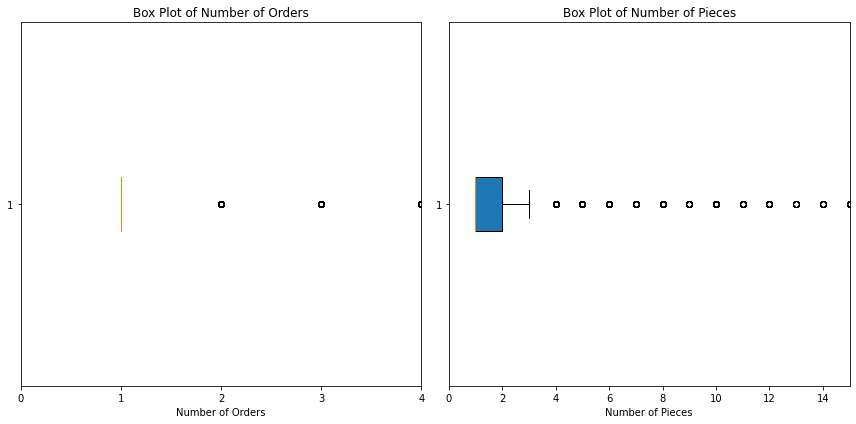

Number of outliers in orders: 1226
Q1 of orders: 1.0
Q3 of orders: 1.0
IQR of orders: 0.0
Number of outliers in pieces: 1097
Q1 of pieces: 1.0
Q3 of pieces: 2.0
IQR of pieces: 1.0


In [45]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

box_orders = axs[0].boxplot(df['NUMBER_ORDERS'], vert=False, patch_artist=True)
axs[0].set_title('Box Plot of Number of Orders')
axs[0].set_xlabel('Number of Orders')

axs[0].set_xlim(left=0, right=df['NUMBER_ORDERS'].quantile(0.95))

median_orders = df['NUMBER_ORDERS'].median()
q1_orders = df['NUMBER_ORDERS'].quantile(0.25)
q3_orders = df['NUMBER_ORDERS'].quantile(0.75)
iqr_orders = q3_orders - q1_orders

outliers_orders = len(df[(df['NUMBER_ORDERS'] < q1_orders - 1.5 * iqr_orders) | (df['NUMBER_ORDERS'] > q3_orders + 1.5 * iqr_orders)])

if 'NUMBER_PIECES' in df.columns:
    box_pieces = axs[1].boxplot(df['NUMBER_PIECES'], vert=False, patch_artist=True)
    axs[1].set_title('Box Plot of Number of Pieces')
    axs[1].set_xlabel('Number of Pieces')

    axs[1].set_xlim(left=0, right=df['NUMBER_PIECES'].quantile(0.95))
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    median_pieces = df['NUMBER_PIECES'].median()
    q1_pieces = df['NUMBER_PIECES'].quantile(0.25)
    q3_pieces = df['NUMBER_PIECES'].quantile(0.75)
    iqr_pieces = q3_pieces - q1_pieces

    outliers_pieces = len(df[(df['NUMBER_PIECES'] < q1_pieces - 1.5 * iqr_pieces) | (df['NUMBER_PIECES'] > q3_pieces + 1.5 * iqr_pieces)])
else:
    outliers_pieces = None
    q1_pieces, q3_pieces, iqr_pieces = None, None, None

plt.tight_layout()
plt.show()

print(f"Number of outliers in orders: {outliers_orders}")
print(f"Q1 of orders: {q1_orders}")
print(f"Q3 of orders: {q3_orders}")
print(f"IQR of orders: {iqr_orders}")
print(f"Number of outliers in pieces: {outliers_pieces}")
print(f"Q1 of pieces: {q1_pieces}")
print(f"Q3 of pieces: {q3_pieces}")
print(f"IQR of pieces: {iqr_pieces}")

In [22]:
user_item_matrix = df.pivot(index='ID_CLIENT', columns='ID_PRODUCT', values='NUMBER_ORDERS').fillna(0)
ratings = user_item_matrix.values

In [23]:
def confidence_matrix(ratings, alpha):
    return 1 + alpha * ratings

In [49]:
def calculate_statistics(matrix):
    stats = {
        'mean': np.mean(matrix),
        'median': np.median(matrix),
        'min': np.min(matrix),
        'max': np.max(matrix),
        'std_dev': np.std(matrix),
        'percentiles': np.percentile(matrix, [25, 50, 75]),
    }
    return stats

alpha = 20
C_train = confidence_matrix(ratings, alpha)


C_train_flat = C_train.flatten()

confidence_stats = calculate_statistics(C_train_flat)

print(f"Mean of confidence matrix: {confidence_stats['mean']}")
print(f"Minimum value in confidence matrix: {confidence_stats['min']}")
print(f"Maximum value in confidence matrix: {confidence_stats['max']}")
print(f"Standard deviation of confidence matrix: {confidence_stats['std_dev']}")

Mean of confidence matrix: 1.0695403459182986
Minimum value in confidence matrix: 1.0
Maximum value in confidence matrix: 10001.0
Standard deviation of confidence matrix: 7.445258166614891


In [24]:
def binarize_preferences(ratings):
    preferences = ratings.copy()
    preferences[preferences != 0] = 1
    return preferences

In [25]:
def update_user_factors(Y, C_u, p_u, lambda_val, YTY):
    Cu_minus_I = C_u - np.eye(Y.shape[0])
    YTCuY = YTY + Y.T @ Cu_minus_I @ Y
    lambda_I = np.eye(Y.shape[1]) * lambda_val
    YTCup_u = Y.T @ C_u @ p_u
    return np.linalg.solve(YTCuY + lambda_I, YTCup_u)

In [26]:

def update_item_factors(X, C_i, p_i, lambda_val, XTX):
    Ci_minus_I = C_i - np.eye(X.shape[0])
    XTCiX = XTX + X.T @ Ci_minus_I @ X
    lambda_I = np.eye(X.shape[1]) * lambda_val
    XTCip_i = X.T @ C_i @ p_i
    return np.linalg.solve(XTCiX + lambda_I, XTCip_i)

In [27]:
def implicit_als_train_test(ratings, alpha=20, lambda_val=0.1, factors=100, iterations=10, test_size=0.2):
    num_users, num_items = ratings.shape

    train_indices, test_indices = train_test_split(np.arange(num_users), test_size=test_size)
    train_ratings = ratings[train_indices]
    test_ratings = ratings[test_indices]

    X = np.random.rand(num_users, factors)
    Y = np.random.rand(num_items, factors)

    P_train = binarize_preferences(train_ratings)
    P_test = binarize_preferences(test_ratings)

    C_train = confidence_matrix(train_ratings, alpha)
    C_test = confidence_matrix(test_ratings, alpha)

    for iteration in range(iterations):
        YTY = Y.T @ Y
        for u in range(len(train_indices)):
            user_idx = train_indices[u]
            C_u = sparse.diags(C_train[u, :])
            p_u = P_train[u, :]
            X[user_idx, :] = update_user_factors(Y, C_u.toarray(), p_u, lambda_val, YTY)

        XTX = X.T @ X
        for i in range(num_items):
            C_i = sparse.diags(C_train[:, i])
            p_i = P_train[:, i]
            Y[i, :] = update_item_factors(X[train_indices, :], C_i.toarray(), p_i, lambda_val, XTX)

        print(f"Iteration {iteration + 1}/{iterations} completed")

    return X, Y, train_indices, test_indices

In [28]:
user_factors, item_factors, train_indices, test_indices = implicit_als_train_test(ratings, alpha=20, lambda_val=0.1, factors=100, iterations=10, test_size=0.2)

Iteration 1/10 completed
Iteration 2/10 completed
Iteration 3/10 completed
Iteration 4/10 completed
Iteration 5/10 completed
Iteration 6/10 completed
Iteration 7/10 completed
Iteration 8/10 completed
Iteration 9/10 completed
Iteration 10/10 completed


In [29]:
from sklearn.metrics import mean_squared_error

def evaluate_model(user_factors, item_factors, test_ratings, test_indices):
    predictions = user_factors[test_indices, :].dot(item_factors.T)
    true_ratings = test_ratings[test_indices, :]
    rmse = np.sqrt(mean_squared_error(true_ratings[true_ratings > 0], predictions[true_ratings > 0]))
    return rmse

# Predizioni sui dati di test
predictions = user_factors[test_indices, :].dot(item_factors.T)
rmse = evaluate_model(user_factors, item_factors, ratings, test_indices)

#print("User Factors:\n", user_factors)
#print("Item Factors:\n", item_factors)
print("RMSE on test set:", rmse)

RMSE on test set: 3.0401764961894346


In [30]:
def generate_rankings(user_factors, item_factors):
    num_users, num_items = user_factors.shape[0], item_factors.shape[0]
    rankings = np.zeros((num_users, num_items))
    
    for u in range(num_users):
        scores = user_factors[u, :] @ item_factors.T
        
        rank_absolute = np.argsort(np.argsort(-scores))
        
        rankings[u, :] = rank_absolute / num_items * 100 

    return rankings

rankings = generate_rankings(user_factors, item_factors)

In [31]:
def calculate_expected_rank(ratings, rankings):
    watched_mask = ratings > 0
    
    rank_values = rankings[watched_mask]
    
    rank_bar = np.mean(rank_values)
    return rank_bar

expected_rank = calculate_expected_rank(ratings, rankings)
print(f"Expected Percentile Rank: {expected_rank:.2f}%")

Expected Percentile Rank: 9.56%


In [32]:
global_mean = np.mean(ratings[ratings > 0])
baseline_predictions = np.full(ratings[test_indices, :].shape, global_mean)
baseline_rmse = np.sqrt(mean_squared_error(ratings[test_indices][ratings[test_indices] > 0], baseline_predictions[ratings[test_indices] > 0]))

print("Baseline RMSE (Global Mean):", baseline_rmse)
print("Model RMSE:", rmse)

Baseline RMSE (Global Mean): 2.580924504115023
Model RMSE: 3.0401764961894346


In [33]:
item_popularity = df.groupby('ID_PRODUCT').size().reset_index(name='popularity')
item_popularity = item_popularity.sort_values(by='popularity', ascending=False).reset_index(drop=True)


def generate_popularity_rankings(num_users, item_popularity):
    num_items = len(item_popularity)
    rankings = np.zeros((num_users, num_items))
    
    for u in range(num_users):
        rankings[u, :] = np.argsort(np.argsort(-item_popularity['popularity'])) / num_items * 100
    
    return rankings

num_users = ratings.shape[0]
popularity_rankings = generate_popularity_rankings(num_users, item_popularity)
popularity_expected_rank = calculate_expected_rank(ratings, popularity_rankings)
print(f"Expected Percentile Rank (Popularity Baseline): {popularity_expected_rank:.2f}%")

model_rankings = generate_rankings(user_factors, item_factors)
model_expected_rank = calculate_expected_rank(ratings, model_rankings)

print(f"Expected Percentile Rank (Model): {model_expected_rank:.2f}%")
print(f"Expected Percentile Rank (Popularity Baseline): {popularity_expected_rank:.2f}%")

if model_expected_rank < popularity_expected_rank:
    print("Il modello performa meglio della baseline basata sulla popolarità.")
else:
    print("La baseline basata sulla popolarità performa meglio del modello.")

Expected Percentile Rank (Popularity Baseline): 56.08%
Expected Percentile Rank (Model): 9.56%
Expected Percentile Rank (Popularity Baseline): 56.08%
Il modello performa meglio della baseline basata sulla popolarità.
